---
# **Section I: Introduction to the problem/task and dataset**

## **Introduction to the Task**
The primary objective of this project is to predict the likelihood of additional goals in a soccer match based on real-time in-game statistics, with the aim of supporting decision-making in sports trading (e.g., over/under betting). By analyzing game-specific metrics, we can estimate scoring potential and influence live trading models for betting and fan engagement.

## **Dataset Overview**
This project’s dataset includes 10,000 unique snapshots of soccer matches at various timestamps, capturing the state of a game through different in-game metrics. Each snapshot includes details on the current score, possession percentages, attempts, and cards, providing a rich dataset for building predictive models.


## **Problem Motivation**
The practical application of predicting match outcomes from live data is significant for team strategy and sports betting, as knowing influential factors—such as possession and dangerous attacks—can improve decision-making and potentially impact match strategies (Kuhn & Johnson, 2013).

---


# **Section 2: Description of the dataset**

### Dataset Overview
The dataset consists of 10,000 randomly selected snapshots from soccer matches, each capturing the in-game state at a specific timestamp. Each row represents a snapshot, detailing scores, possession, and other match features, which collectively provide a momentary overview of game dynamics (Anguera et al., 2018).

### Data Collection
This dataset was collected through in-game analytics systems that continuously monitor and record essential match metrics. Although highly detailed, this collection method might introduce minor noise due to the rapid state changes inherent in live sports (Yin & Leong, 2017).

### Dataset Structure 
- **Rows**: Each row represents a single timestamp during a soccer match.
- **Columns**: Key features include:
  - **Identifier**: `uuid` - Unique identifier for each snapshot.
  - **Time**: `current_minute` - Game minute, including a 15-minute half-time, making the total match time 105 minutes.
  - **Scores**: `home_score`, `away_score`
  - **Cards**: Yellow and red cards for both teams.
  - **Gameplay Metrics**: Attacks, dangerous attacks, and shots on/off target for each team.
  - **Possession**: Ball possession percentages for each team.
  - **Target**: `final_delta` - The number of goals scored by any team. The target value for the prediction.

---


# **Section 3: List of requirements**

### Python Libraries


> Add more if may gagamitin pa


The following libraries are required to support data analysis, model training, and evaluation:
- **Data Manipulation**:
  - `pandas`: Data manipulation and cleaning (McKinney, 2011).
  - `numpy`: Numerical operations (Oliphant, 2006).
- **Data Visualization**:
  - `matplotlib`: For line and bar charts (Hunter, 2007).
  - `seaborn`: For statistical graphics (Waskom, 2021).
- **Machine Learning and Model Evaluation**:
  - `scikit-learn`: For k-NN, Linear Regression, Neural Networks, and model validation (Pedregosa et al., 2011).
  - 
- **Hyperparameter Tuning**:
  - `scikit-learn`: For grid search and random search.
- **Metrics**:
  - `scikit-learn.metrics`: 


In [81]:
# Data Manipulation
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning Models
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error ,r2_score



In [42]:
np.random.seed(42)

# **Section 4: Data preprocessing and cleaning**

#### Cleaning Steps
- **Checking for Duplicates**: Removing redundant rows to ensure unique snapshots.
- **Type Conversion**: Ensuring all features are in suitable formats (e.g., integer for score-related features, float for percentages).
- **Handling Missing Values**: Uses techniques like imputation if necessary, based on the dataset's nature.
- **Outlier Detection**: Detects anomalies in numerical features, which may skew predictions if left unaddressed.

#### Preprocessing Techniques
Key techniques include:
- **Feature Scaling**: Since features have different units (e.g., score vs. possession percentage), scaling is essential to ensure model performance, particularly for k-NN and Neural Networks (Han et al., 2011).

### **I. Load and Inspect the Data**
- Initial Check: Start by inspecting the data types, missing values, and unique values. This helps determine what cleaning actions are necessary (Han et al., 2011).
- Data Types: Confirm the data types for each column, ensuring numerical values are correctly identified for calculations and models.


In [43]:
df = pd.read_csv('sports.csv', index_col="uuid")
df.head()

,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,home_off_target,away_off_target,home_on_target,away_on_target,home_possession,away_possession,final_delta
uuid,,,,,,,,,,,,,,,,,,,,
2f9dd904-8d9d-4aa0-a9d9-4e0f3e50d742,94,1,2,0,0,0,0,39,45,29,26,4,1,4,0,4,6,48,52,1
869c1420-9153-4d73-8d79-5db31a8a80a4,91,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50,50,1
549e25a3-4c93-459d-b115-fb303273c78a,3,0,0,0,0,0,0,3,1,1,0,0,0,0,0,0,0,62,38,4
287b4be5-9163-4e2e-895d-d11052a97410,17,0,0,1,0,0,0,41,46,11,25,1,0,0,2,0,0,55,45,2
a607da6a-d6b2-4652-b7a5-6c8e4b61c2b8,76,1,0,1,0,0,0,69,78,21,46,1,1,0,3,4,4,45,55,0


In [44]:
df = df.reset_index(col_level=0)
df = df.drop('uuid', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   current_minute          7000 non-null   int64
 1   home_score              7000 non-null   int64
 2   away_score              7000 non-null   int64
 3   home_yellow_cards       7000 non-null   int64
 4   away_yellow_cards       7000 non-null   int64
 5   home_red_cards          7000 non-null   int64
 6   away_red_cards          7000 non-null   int64
 7   home_attacks            7000 non-null   int64
 8   away_attacks            7000 non-null   int64
 9   home_dangerous_attacks  7000 non-null   int64
 10  away_dangerous_attacks  7000 non-null   int64
 11  home_corners            7000 non-null   int64
 12  away_corners            7000 non-null   int64
 13  home_off_target         7000 non-null   int64
 14  away_off_target         7000 non-null   int64
 15  home_on_target       

#### Check ranges of values for each feature to determine invalid / unrealistic values

In [45]:
# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T

,min,max,median,mean
current_minute,-348.0,583.0,70.0,59.491571
home_score,0.0,8.0,0.0,0.796000
away_score,0.0,9.0,0.0,0.623143
home_yellow_cards,0.0,8.0,0.0,0.522429
away_yellow_cards,0.0,8.0,0.0,0.603143
home_red_cards,0.0,2.0,0.0,0.009286
away_red_cards,0.0,2.0,0.0,0.015714
home_attacks,0.0,255.0,43.0,46.365429
away_attacks,0.0,183.0,41.0,43.325143
home_dangerous_attacks,0.0,134.0,25.0,27.611429


### II. Remove Unrealistic Values and Outliers
- Current Minute: Limit values between 0 and 105 (including a 90-minute match plus 15 minutes for half-time).
- Yellow Cards: Set a threshold of 5 yellow cards per team, as higher values are rare.
Attacks and Dangerous Attacks: Apply upper bounds of 150 for attacks and 100 for dangerous attacks, considering typical gameplay stats.
`may citation ba 2 / src?`

- Possession Percentages: Filter for rows where the sum of home_possession and away_possession is close to 100%, with a tolerance of ±2% to give way for rounding discrepancies

- final_delta: Filter out negative values, since goals should be a nonnegative value

In [46]:
# Filter for realistic match time
df = df[(df['current_minute'] >= 0) & (df['current_minute'] <= 105)]

# Limit yellow cards to realistic maximum
df = df[(df['home_yellow_cards'] <= 5) & (df['away_yellow_cards'] <= 5)]

# Limit attacks and dangerous attacks
df = df[(df['home_attacks'] <= 150) & (df['away_attacks'] <= 150)]
df = df[(df['home_dangerous_attacks'] <= 100) & (df['away_dangerous_attacks'] <= 100)]

# Check possession totals with a tolerance
df = df[np.isclose(df['home_possession'] + df['away_possession'], 100, atol=2)]

In [47]:
# Only include rows with nonnegative final_delta
df_len = len(df)
print(f'Number of rows: {df_len}')
df = df.drop(df[df['final_delta'] < 0].index)
print(f'After dropping: {len(df)} (-{df_len- len(df)})')

Number of rows: 6732
After dropping: 6729 (-3)


In [48]:
dupes = df.duplicated().sum()
print(f'Number of duplicate rows: {dupes}')

df_w_dupes = len(df)
df = df.drop_duplicates()

print(f'After dropping: {len(df)} (-{df_w_dupes- len(df)})')

Number of duplicate rows: 103
After dropping: 6626 (-103)


### **III. Normalize Features**
- For `current_minute`, disregard half-time break of 15 minutes since the snapshot does not change within this period

In [49]:
# if current_minute in (45,60) then set to 45 (currently on break)
# if current_minute > 60, subtract by 15

original_minutes = df['current_minute'].copy()

df['current_minute'] = df['current_minute'].apply(
    lambda x: 45 if x in [45, 60] else (x - 15 if x > 60 else x)
)

# Count the number of rows affected
rows_affected = (df['current_minute'] != original_minutes).sum()
print(f'Number of rows affected: {rows_affected}')

Number of rows affected: 3749


### **IV. Feature Engineering**
- Adding new features can capture dynamics between the two teams and improve predictive performance:
  * Goal Difference: A feature that shows the goal lead or deficit, useful in classification tasks related to match outcome (Kuhn & Johnson, 2013).
  * Attack Efficiency: Calculate the ratio of on-target shots to total shots, showing how effectively each team converts attacks into potential goals.
  * Possession Balance: Calculating the difference in possession provides insight into the team that controls the game.

In [50]:
df['home_attack_efficiency'] = df['home_on_target'] / (df['home_on_target'] + df['home_off_target'] + 1e-5)
df['away_attack_efficiency'] = df['away_on_target'] / (df['away_on_target'] + df['away_off_target'] + 1e-5)
df['possession_balance'] = df['home_possession'] - df['away_possession']

df = df.drop(["home_on_target", "away_on_target",
              "home_off_target","away_off_target", 
              "home_possession", "away_possession"], 
              axis=1)

### VI. Final Checks
- Cap Extreme Efficiency Ratios: Limit values for home_attack_efficiency and away_attack_efficiency to a reasonable upper bound (e.g., 1 for 100% efficiency).
- Recheck for NaNs: After calculating efficiency ratios and capping values, ensure no NaNs were introduced.


In [51]:
print(df['home_attack_efficiency'].describe())
print()
print(df['away_attack_efficiency'].describe())
print()
print("Number of NaNs:", df.isna().sum(), sep="\n")  # Confirm no missing values remain

count    6626.000000
mean        0.336898
std         0.300963
min         0.000000
25%         0.000000
50%         0.333332
75%         0.499999
max         0.999999
Name: home_attack_efficiency, dtype: float64

count    6626.000000
mean        0.323139
std         0.307008
min         0.000000
25%         0.000000
50%         0.333332
75%         0.499999
max         0.999999
Name: away_attack_efficiency, dtype: float64

Number of NaNs:
current_minute            0
home_score                0
away_score                0
home_yellow_cards         0
away_yellow_cards         0
home_red_cards            0
away_red_cards            0
home_attacks              0
away_attacks              0
home_dangerous_attacks    0
away_dangerous_attacks    0
home_corners              0
away_corners              0
final_delta               0
home_attack_efficiency    0
away_attack_efficiency    0
possession_balance        0
dtype: int64


### VIII. Final Validation:
- Data Type Validation: Ensure all features are correctly typed as either integer or float.
- Feature Correlation: Check correlations to identify highly correlated variables, which may inform feature selection (if necessary).

In [52]:
# Statistical Summaries of All Feature 
df.agg(['min', 'max', 'median', 'mean']).T


,min,max,median,mean
current_minute,0.0,90.000000,54.000000,49.591911
home_score,0.0,8.000000,0.000000,0.779807
away_score,0.0,9.000000,0.000000,0.608210
home_yellow_cards,0.0,5.000000,0.000000,0.497585
away_yellow_cards,0.0,5.000000,0.000000,0.573046
home_red_cards,0.0,2.000000,0.000000,0.008602
away_red_cards,0.0,2.000000,0.000000,0.014337
home_attacks,0.0,150.000000,42.000000,45.124660
away_attacks,0.0,148.000000,40.000000,42.445518
home_dangerous_attacks,0.0,100.000000,24.000000,26.820404


In [53]:
print(f"Final shape: {df.shape}")
df.head()

Final shape: (6626, 17)


,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,final_delta,home_attack_efficiency,away_attack_efficiency,possession_balance
0,79,1,2,0,0,0,0,39,45,29,26,4,1,1,0.499999,0.999998,-4
1,76,2,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0
2,3,0,0,0,0,0,0,3,1,1,0,0,0,4,0.000000,0.000000,24
3,17,0,0,1,0,0,0,41,46,11,25,1,0,2,0.000000,0.000000,10
4,61,1,0,1,0,0,0,69,78,21,46,1,1,0,0.999998,0.571428,-10


`[will fix this pa wait]`

References:
Aggarwal, C. C. (2017). Outlier analysis. Springer International Publishing. 
Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier.
Jain, A., & Zongker, D. (1997). Feature selection: Evaluation, application, and small sample performance. IEEE Transactions on Pattern Analysis and Machine Intelligence, 19(2), 153-158.
Kang, H. (2013). The prevention and handling of the missing data. Korean Journal of Anesthesiology, 64(5), 402-406.
Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer.
Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830.


---

# **Section 5: Exploratory data analysis**

 * ### Check correlation of each feature with the target value, `final_delta`

C:\Users\Ryan\AppData\Local\Temp\ipykernel_22024\1141341187.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')


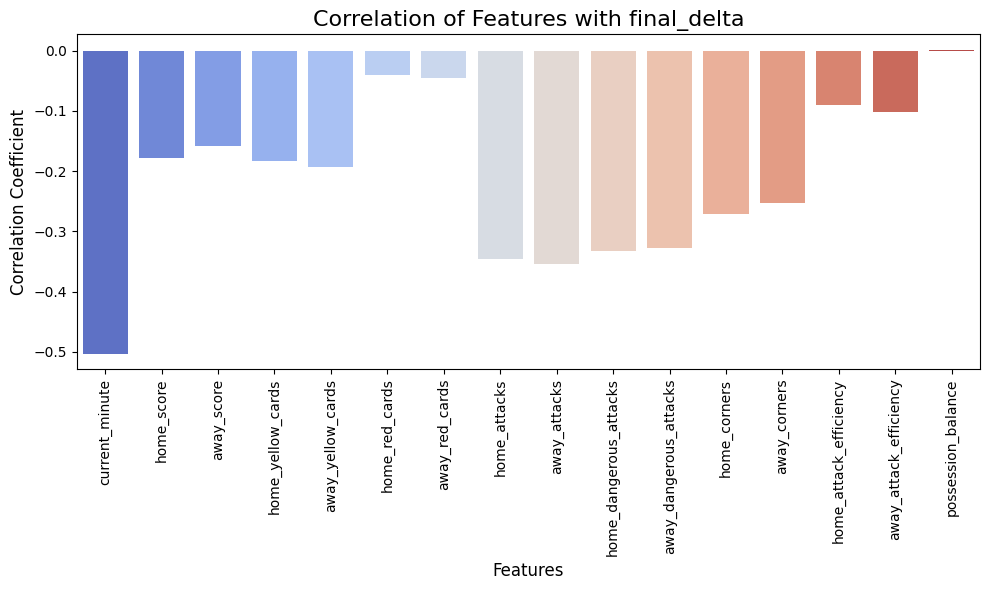

current_minute           -0.503000
home_score               -0.178096
away_score               -0.158045
home_yellow_cards        -0.183926
away_yellow_cards        -0.193081
home_red_cards           -0.040799
away_red_cards           -0.044927
home_attacks             -0.346378
away_attacks             -0.353528
home_dangerous_attacks   -0.332882
away_dangerous_attacks   -0.326906
home_corners             -0.271910
away_corners             -0.252431
home_attack_efficiency   -0.089759
away_attack_efficiency   -0.101352
possession_balance        0.001915
Name: final_delta, dtype: float64


In [54]:
# Calculate correlation of each feature with `final_delta`
correlations = df.corr()['final_delta'].drop('final_delta')

# Plot the correlation graph
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette='coolwarm')

# Add labels and titles

plt.xticks(rotation=90)
plt.title('Correlation of Features with final_delta', fontsize=16)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()
print(correlations)

### Pairwise Correlation of each Feature

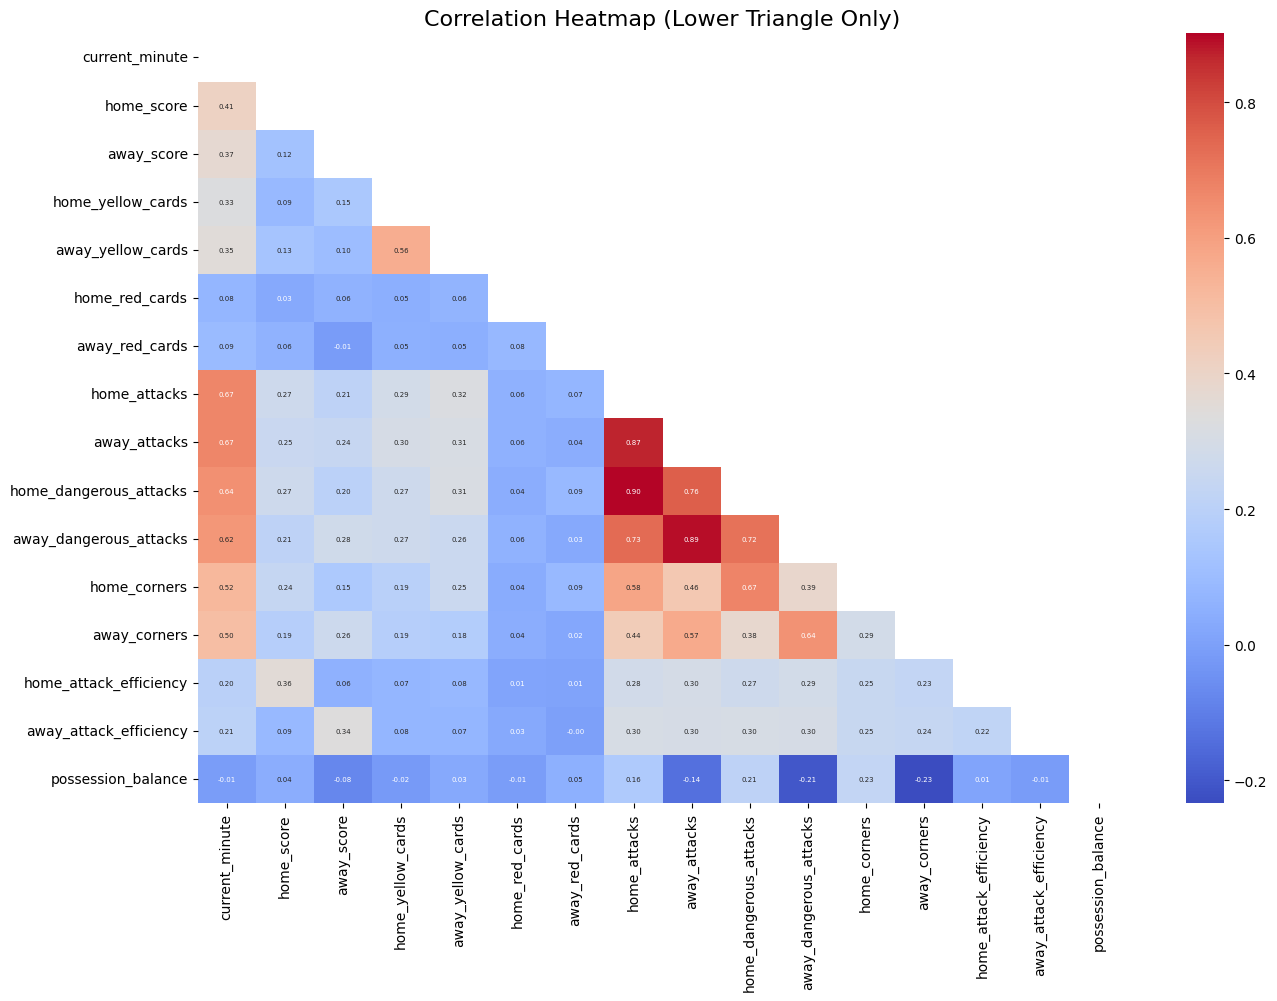

In [55]:
corr_matrix = df.drop('final_delta', axis=1).corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Remove repeated pairs

fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corr_matrix, mask=mask, ax=ax, annot=True, annot_kws={'size': 5}, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap (Lower Triangle Only)', fontsize=16)
plt.show()

The following pairs of features have high correlation with each other: 
- home_attacks and home_dangerous_attacks (and the away equivalent) - positive 
- home_attacks and away_attacks - positive
- away_corners and possession_balance - negative
- away_corners and possession_balance - negative 

In general, the attack-related features have high positive correlations with each other (a sign we can generalize these as one feature?)

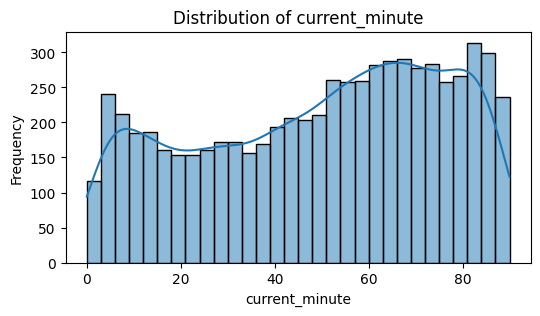

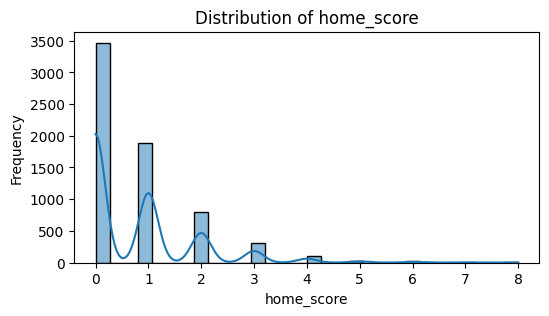

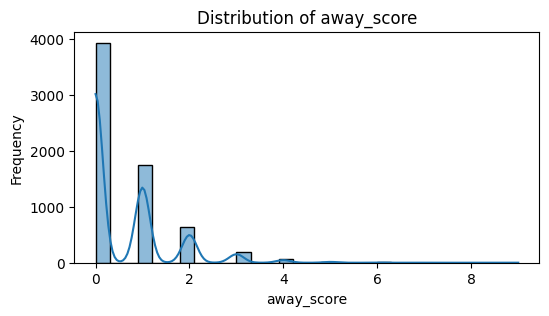

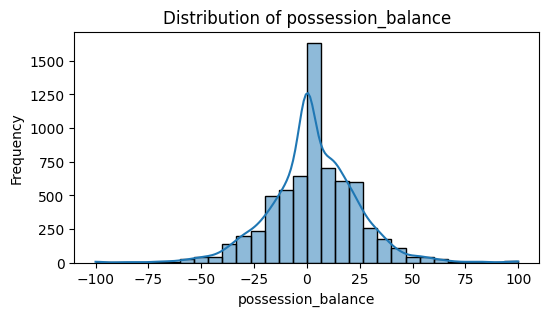

In [60]:
# Visualize distributions using histograms

numerical_cols = [ 'current_minute','home_score', 'away_score', 'possession_balance']


# Histogram plot
for col in numerical_cols:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# ### Boxplot
# for col in numerical_cols:
#     plt.figure(figsize=(6, 3))
#     sns.boxplot(x=df[col])
#     plt.title(f"Boxplot of {col}")
#     plt.xlabel(col)
#     plt.show()

### Analysis for Attack-related features over Match Time

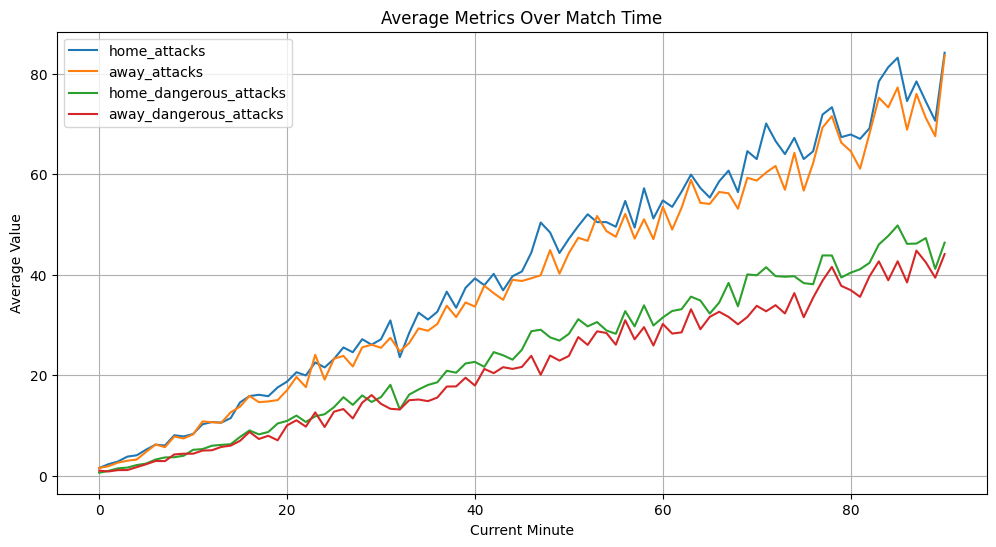

In [75]:
# Group by current_minute and calculate mean values for key metrics
time_analysis = df.groupby('current_minute').mean()
time_metrics = ['home_attacks', 'away_attacks', 'home_dangerous_attacks', 'away_dangerous_attacks']

plt.figure(figsize=(12, 6))
for metric in time_metrics:
    plt.plot(time_analysis.index, time_analysis[metric], label=metric)
plt.title("Average Metrics Over Match Time")
plt.xlabel("Current Minute")
plt.ylabel("Average Value")
plt.legend()
plt.grid()
plt.show()


---

# **Section 6: Initial model training**

In [62]:
X = df.drop("final_delta", axis=1)
y = df['final_delta']

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (6626, 16)
Shape of y: (6626,)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3 ,random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (4638, 16)
Shape of X_test: (1988, 16)


## **Model 1: Linear Regression using Batch Gradient Descent (order=1)**

In [64]:
# Preprocess LR Model by standardizing features
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [65]:
# Set up base model 
sgd = SGDRegressor(
    loss="squared_error", 
    penalty='l1', 
    learning_rate='constant',
    random_state=42,
    tol=0.0001, 
    verbose=True,
    )


In [66]:
sgd.fit(X_train_sc, y_train)

-- Epoch 1
Norm: 0.88, NNZs: 15, Bias: 1.516445, T: 4638, Avg. loss: 0.861185
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 1.17, NNZs: 15, Bias: 1.330009, T: 9276, Avg. loss: 0.836480
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 1.60, NNZs: 13, Bias: 1.341484, T: 13914, Avg. loss: 0.832872
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 2.07, NNZs: 14, Bias: 1.600599, T: 18552, Avg. loss: 0.835351
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 2.45, NNZs: 14, Bias: 1.389468, T: 23190, Avg. loss: 0.835104
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 2.85, NNZs: 11, Bias: 1.593195, T: 27828, Avg. loss: 0.830729
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 3.20, NNZs: 11, Bias: 1.438034, T: 32466, Avg. loss: 0.826920
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 3.57, NNZs: 12, Bias: 1.643034, T: 37104, Avg. loss: 0.818585
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 3.92, NNZs: 15, Bias: 1.502312, T: 41742, Avg. loss: 0.821304
Total train

SGDRegressor(learning_rate='constant', penalty='l1', random_state=42,
             tol=0.0001, verbose=True)

In [67]:
weights = pd.DataFrame({
    'Feature': X_train.columns,
    'coef': sgd.coef_
})

weights = pd.concat(
    [weights, pd.DataFrame({'Feature': ['bias'], 
                            'coef':[sgd.intercept_]})],
    ignore_index=True
)

weights = weights.set_index('Feature').T
weights

Feature,current_minute,home_score,away_score,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,home_attacks,away_attacks,home_dangerous_attacks,away_dangerous_attacks,home_corners,away_corners,home_attack_efficiency,away_attack_efficiency,possession_balance,bias
coef,-0.66123,0.151237,0.039682,0.0,0.05191,-0.012596,0.0,0.006157,-0.044299,0.0,0.0,0.0,0.052017,0.0,0.0,0.0,[1.5464922799695235]


In [ ]:
# Get training score 
preds = sgd.predict(X_train_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
rmse = root_mean_squared_error(preds, y_train)
mse = mean_squared_error(preds, y_train)

print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [0. 1. 2. 3.]
RMSE: 1.304617
MSE: 1.702027


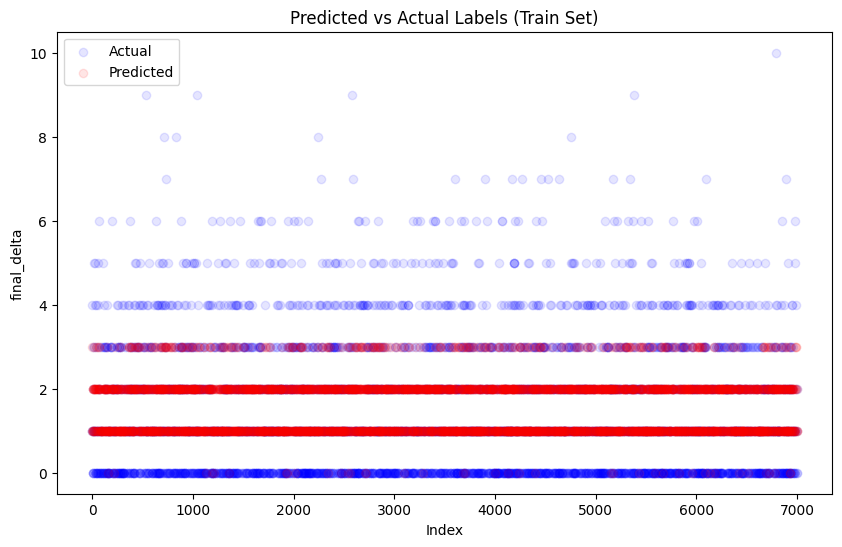

In [69]:
plt.figure(figsize=(10,6))
plt.scatter(X_train.index, y_train, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_train.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Train Set)")
plt.legend()

plt.show()

In [70]:
# Get testing score 

preds = sgd.predict(X_test_sc)
preds = np.round(preds)

print(f"Range of predicted values: {np.unique(preds)}" )
rmse = root_mean_squared_error(preds, y_test)
mse = mean_squared_error(preds, y_test)

print(f"RMSE: {rmse:.6f}")
print(f"MSE: {mse:.6f}")

Range of predicted values: [0. 1. 2. 3.]
RMSE: 1.264354
MSE: 1.598592


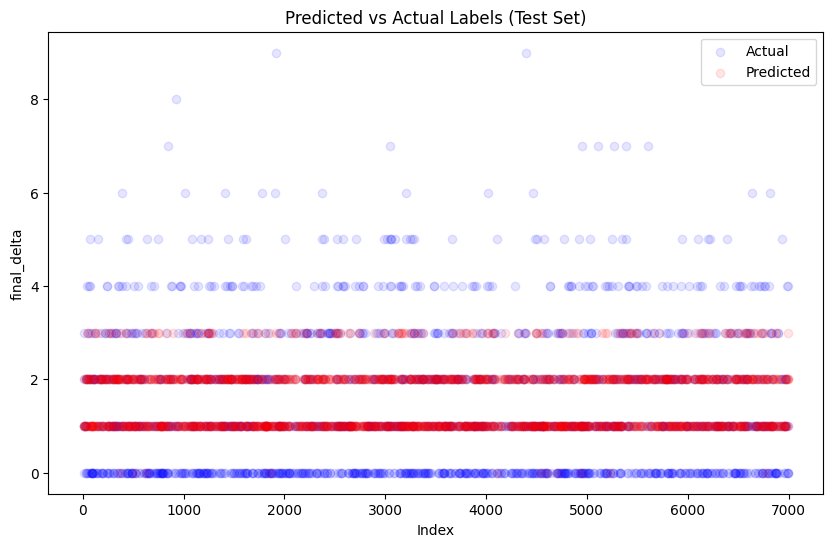

In [71]:
plt.figure(figsize=(10,6))
plt.scatter(X_test.index, y_test, color='blue', label="Actual", alpha=0.1)
plt.scatter(X_test.index, preds, color='red', label="Predicted", alpha=0.1)

plt.xlabel("Index")
plt.ylabel("final_delta")
plt.title("Predicted vs Actual Labels (Test Set)")
plt.legend()

plt.show()

## Model 2: Neural Networks using MLPRegressor 

In [72]:
# Initialize the MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', max_iter=300, solver='adam', random_state=42, verbose=True)

# Train the model
mlp.fit(X_train, y_train)

Iteration 1, loss = 3.02506769
Iteration 2, loss = 1.45835013
Iteration 3, loss = 1.32507752
Iteration 4, loss = 1.25886690
Iteration 5, loss = 1.17519204
Iteration 6, loss = 1.11811927
Iteration 7, loss = 1.06166232
Iteration 8, loss = 1.03233924
Iteration 9, loss = 0.99446101
Iteration 10, loss = 0.95673208
Iteration 11, loss = 0.96842249
Iteration 12, loss = 0.94018270
Iteration 13, loss = 0.87855247
Iteration 14, loss = 0.87566391
Iteration 15, loss = 0.89731428
Iteration 16, loss = 0.84363360
Iteration 17, loss = 0.82937072
Iteration 18, loss = 0.81732585
Iteration 19, loss = 0.81600683
Iteration 20, loss = 0.87906866
Iteration 21, loss = 0.80222851
Iteration 22, loss = 0.81989295
Iteration 23, loss = 0.80291662
Iteration 24, loss = 0.76818445
Iteration 25, loss = 0.75550228
Iteration 26, loss = 0.78570908
Iteration 27, loss = 0.75819656
Iteration 28, loss = 0.77442558
Iteration 29, loss = 0.76288204
Iteration 30, loss = 0.78096186
Iteration 31, loss = 0.76944235
Iteration 32, los

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42,
             verbose=True)

In [74]:
# Predict on the test set
y_pred = mlp.predict(X_test)

# Apply ceiling to the predicted values
y_pred = np.round(y_pred)

# Evaluate the model
rmse = root_mean_squared_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')


print(np.unique(y_pred))

comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

comparison_df.head(15)

RMSE: 1.2732742690344099
Mean Squared Error (MSE): 1.6212273641851107
Mean Absolute Error (MAE): 0.9361167002012073
R^2 Score: 0.18235998000603082
[0. 1. 2. 3. 4. 5.]


,Actual,Predicted
4786,0,1.0
4670,1,1.0
4110,5,3.0
4971,0,2.0
4721,2,2.0
1602,0,0.0
6269,3,1.0
2024,0,2.0
5941,2,3.0
2512,2,1.0


## Model 2: Random Forest Regressor

In [82]:
# Create the random forest regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42, verbose=True)

# Fit the model
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


RandomForestRegressor(random_state=42, verbose=True)

In [83]:
#train the regressor
rf_regressor.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.0s


RandomForestRegressor(random_state=42, verbose=True)

In [84]:
# Access the depths of all trees in the Random Forest
tree_depths = [tree.tree_.max_depth for tree in rf_regressor.estimators_]

# Print the depths of d trees
print("Tree depths:", tree_depths)

# solve and print the avg depth of the trees
average_depth = sum(tree_depths) / len(tree_depths)
print("Average depth of trees:", average_depth)

Tree depths: [33, 31, 37, 32, 32, 29, 28, 33, 28, 27, 26, 25, 30, 30, 28, 29, 30, 27, 30, 31, 27, 26, 33, 31, 25, 27, 26, 28, 25, 29, 30, 27, 26, 25, 29, 28, 33, 31, 31, 25, 28, 35, 27, 31, 27, 26, 30, 27, 26, 28, 31, 26, 31, 25, 25, 28, 28, 31, 29, 24, 31, 31, 27, 29, 24, 25, 25, 27, 27, 29, 26, 29, 28, 27, 31, 30, 29, 35, 27, 25, 29, 37, 28, 30, 24, 25, 26, 30, 31, 31, 26, 27, 28, 30, 26, 31, 25, 35, 28, 32]
Average depth of trees: 28.62


In [85]:
# Evaluate on test data )
y_pred = rf_regressor.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

Test MSE: 1.555454450203734
Test RMSE: 1.2471785959531754
Test R²: 0.21553149431107443


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


---

# **Section 7: Error analysis**

## On Random Forest

In [86]:
#visualize the errors (from MSE, RMSE, R2)

#will use OOB kasi validation set is not necessary since ensemble learning si RF
print("Evaluting Test Data Results:")
print(f"Test MSE: {test_mse}")
print(f"Test RMSE: {test_rmse}")
print(f"Test R²: {test_r2}")

rf_regressor = RandomForestRegressor(n_estimators=100, 
                                     random_state=42, 
                                     oob_score=True, 
                                     verbose=True)
rf_regressor.fit(X_train, y_train)
oob_score = rf_regressor.oob_score_

# If you also want to compute OOB prediction error (MSE or RMSE for OOB samples):
oob_predictions = rf_regressor.oob_prediction_
oob_mse = mean_squared_error(y_train, oob_predictions)
oob_rmse = np.sqrt(oob_mse)
oob_r2 = r2_score(y_train, oob_predictions)
print("\nEvaluting Out-Of-Bag(OOB) Data Results:")
print(f"OOB MSE: {oob_mse}")
print(f"OOB RMSE: {oob_rmse}")
print(f"OOB R²: {oob_r2}")
print(f"\nOOB Score: {oob_score}")

#residual plot

#actual vs predicted plot

Evaluting Test Data Results:
Test MSE: 1.555454450203734
Test RMSE: 1.2471785959531754
Test R²: 0.21553149431107443


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    1.1s



Evaluting Out-Of-Bag(OOB) Data Results:
OOB MSE: 1.6913802761397958
OOB RMSE: 1.3005307670869597
OOB R²: 0.1662072091359289

OOB Score: 0.1662072091359289


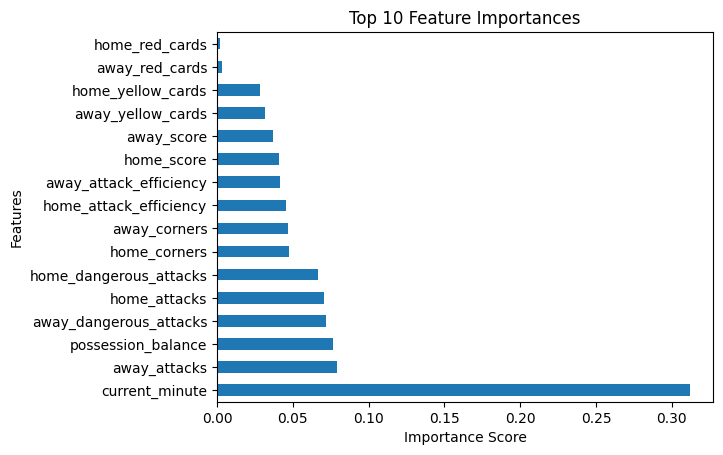

current_minute            0.311703
away_attacks              0.078767
possession_balance        0.076770
away_dangerous_attacks    0.071599
home_attacks              0.070206
home_dangerous_attacks    0.066386
home_corners              0.047640
away_corners              0.046450
home_attack_efficiency    0.045630
away_attack_efficiency    0.041717
home_score                0.041003
away_score                0.037075
away_yellow_cards         0.031320
home_yellow_cards         0.028283
away_red_cards            0.003497
home_red_cards            0.001954
dtype: float64


In [87]:
#identify difficult to predict data points
#feature importance
plt.figure()
# Applying the ExtraTreesRegressor for feature importance
model = ExtraTreesRegressor()
model.fit(X, y)

# Extracting feature importances
feat_importances = pd.Series(model.feature_importances_, index=X.columns)

# Plotting the top 10 important features
feat_importances.nlargest(20).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

# Displaying the feature importances for reference
print(feat_importances.sort_values(ascending=False))

---

# **Section 8: Improving model performance**

---

# **Section 9: Model performance summary**

---

# **Section 10: Insights and conclusions**

---

# **Section 11: References**



> Dump Ref muna fix it later

https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

https://ieeexplore.ieee.org/document/4160265

https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

https://web.mit.edu/dvp/Public/numpybook.pdf

https://dl.acm.org/doi/10.5555/1953048.2078195

https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

https://archive.org/details/exploratorydataa0000tuke_7616

---

- Anguera, M. T., Blanco-Villaseñor, A., Losada, J. L., & Perea, M. V. (2018). Sports analysis and prediction: New challenges and approaches. Frontiers in Psychology, 10, 501. https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2019.00501/full

- Yin, D., & Leong, S. Y. (2017). Predictive modeling in soccer analytics. International Journal of Sports Management and Marketing, 7(3), 235-248. https://www.sciencedirect.com/science/article/abs/pii/S0169207018300116

- Kuhn, M., & Johnson, K. (2013). Applied predictive modeling. Springer Science & Business Media. https://warin.ca/ressources/books/2013_Book_AppliedPredictiveModeling.pdf

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. https://ieeexplore.ieee.org/document/4160265

- McKinney, W. (2011). pandas: A foundational Python library for data analysis and manipulation. Python for Data Analysis, O'Reilly Media. https://www.researchgate.net/publication/265194455_pandas_a_Foundational_Python_Library_for_Data_Analysis_and_Statistics

- Oliphant, T. E. (2006). A guide to NumPy. Trelgol Publishing. https://web.mit.edu/dvp/Public/numpybook.pdf

- Pedregosa, F., et al. (2011). Scikit-learn: Machine learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://dl.acm.org/doi/10.5555/1953048.2078195

- Waskom, M. L. (2021). Seaborn: Statistical data visualization. Journal of Open Source Software, 6(60), 3021. https://www.researchgate.net/publication/350701622_seaborn_statistical_data_visualization

- Han, J., Kamber, M., & Pei, J. (2011). Data mining: Concepts and techniques. Elsevier. https://www.sciencedirect.com/book/9780123814791/data-mining-concepts-and-techniques

- Tukey, J. W. (1977). Exploratory data analysis. Addison-Wesley. https://archive.org/details/exploratorydataa0000tuke_7616